# MLE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from scipy.stats import chi2_contingency

In [3]:
from functools import reduce
import itertools

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

## Load Data

In [5]:
!ls

01_dataPrep.sas
01_MLE.ipynb
01_MLE_v02.ipynb
01_MLE_v03.ipynb
3TS.pptx
adult.csv
adult-census-income.sas
adult-census-income.zip
adultCensusIncome_score.csv
adultCensusIncome_score_target.csv
adultCensusIncome_train.csv
census_income.egp
score.csv
score_label.csv
train.csv


In [6]:
!head -n 10 adultCensusIncome_train.csv

incGE50k,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,id
0,90,,77053,HS-grad,9,Widowed,,Not-in-family,White,Female,0,4356,40,United-States,1
0,66,,186061,Some-college,10,Widowed,,Unmarried,Black,Female,0,4356,40,United-States,3
0,,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,4
0,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,6
0,68,Federal-gov,422013,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,0,3683,40,United-States,8
0,29,Private,77009,11th,7,Separated,Sales,Not-in-family,White,Female,0,2754,42,United-States,9
0,61,Private,29059,HS-grad,9,Divorced,Sales,Unmarried,White,Female,0,2754,25,United-States,10
0,51,Private,153870,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,2603,40,United-States,11
0,61,,135285,HS-grad,9,Married-civ-spouse,,H

In [7]:
train = pd.read_csv("train.csv")
train["flg_train"] = 1

score = pd.read_csv("score.csv")
score["flg_train"] = 0

data= train.append(score)
data[:5]

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,age,capital_gain,capital_loss,education,education_num,flg_train,fnlwgt,hours_per_week,id,incGE50k,marital_status,native_country,occupation,race,relationship,sex,workclass
0,66.0,0,4356,Some-college,10,1,186061,40,3,0.0,Widowed,United-States,NaN,Black,Unmarried,Female,NaN
1,54.0,0,3900,7th-8th,4,1,140359,40,4,0.0,Divorced,United-States,Machine-op-inspct,White,Unmarried,Female,Private
2,41.0,0,3900,Some-college,10,1,264663,40,5,0.0,Separated,United-States,Prof-specialty,White,Own-child,Female,Private
3,34.0,0,3770,HS-grad,9,1,216864,45,6,0.0,Divorced,United-States,Other-service,White,Unmarried,Female,Private
4,NaN,0,3770,10th,6,1,150601,40,7,0.0,Separated,United-States,Adm-clerical,White,Unmarried,Male,Private


In [8]:
label = "incGE50k"
id = "id"

n_train = train.shape[0]
n_score = score.shape[0]
n_data = n_train + n_score
print("Number of observations in train {:,} and in score {:,}".format(n_train, n_score))

Number of observations in train 24,420 and in score 8,141


## Metadata Analysis

In [9]:
num_features = [feature for feature in data.select_dtypes(exclude=['object']).columns.values if feature not in [label, id, "flg_train"]]
str_features = [feature for feature in data.select_dtypes(include=['object']).columns.values if feature not in [label, id, "flg_train"]]

print("Numeric features ({}): {} \nString features ({}): {}".format(len(num_features), num_features, len(str_features), str_features) )

Numeric features (6): ['age', 'capital_gain', 'capital_loss', 'education_num', 'fnlwgt', 'hours_per_week'] 
String features (8): ['education', 'marital_status', 'native_country', 'occupation', 'race', 'relationship', 'sex', 'workclass']


 ## Univariate EDA

### Response Analysis

In [10]:
eprop = data[label].mean()

print("Event proportion:", eprop)

Event proportion: 0.2339066339066339


### Descriptive Statistics
* Numeric Descriptive Statistics
* Categorical data Descriptive Statistics
* checkMissing
* checkSkewness
* checkCatFreq

In [11]:
stats_num_train = train[num_features].describe().T
stats_num_score = score[num_features].describe().T
stats_num = pd.merge(stats_num_train, stats_num_score, how="left", left_index=True, right_index=True)
stats_num[["count_x", "count_y", "mean_x", "mean_y", "std_x", "std_y", "min_x","min_y","max_x","max_y"]]

,count_x,count_y,mean_x,mean_y,std_x,std_y,min_x,min_y,max_x,max_y
age,17223.0,5701.0,41.162109,41.163480,14.335114,14.240205,17.0,17.0,90.0,90.0
capital_gain,24420.0,8141.0,1099.821007,1011.140523,7538.390911,6905.738675,0.0,0.0,99999.0,99999.0
capital_loss,24420.0,8141.0,87.164947,87.720427,402.808797,403.438561,0.0,0.0,4356.0,4356.0
education_num,24420.0,8141.0,10.072236,10.106007,2.573961,2.568987,1.0,1.0,16.0,16.0
fnlwgt,24420.0,8141.0,189374.781491,190988.972853,104634.017743,108248.550878,12285.0,14878.0,1366120.0,1484705.0
hours_per_week,24420.0,8141.0,40.476945,40.319003,12.336379,12.380518,1.0,1.0,99.0,99.0


In [12]:
num_features = [feature for feature in num_features if feature not in ["education_num"]]
str_features = str_features #+ ["education_num"]

In [13]:
stats_str_train = train.describe(include=["O"]).T
stats_str_score = score.describe(include=["O"]).T
stats_str = pd.merge(stats_str_train, stats_str_score, how="left", left_index=True, right_index=True)
stats_str[["count_x", "count_y", "top_x", "top_y", "freq_x", "freq_y", "unique_x", "unique_y"]]

,count_x,count_y,top_x,top_y,freq_x,freq_y,unique_x,unique_y
workclass,23041,7684,Private,Private,17035,5661,8,8
education,24420,8141,HS-grad,HS-grad,7886,2615,16,16
marital_status,24420,8141,Married-civ-spouse,Married-civ-spouse,11221,3755,7,7
occupation,23037,7681,Prof-specialty,Craft-repair,3147,1061,14,14
relationship,24420,8141,Husband,Husband,9855,3338,6,6
race,24420,8141,White,White,20885,6931,5,5
sex,24420,8141,Male,Male,16287,5503,2,2
native_country,23986,7991,United-States,United-States,21843,7279,58,49


In [14]:
def checkMissing(data_df, flg_train_col, label_col, n_train, n_score):
    df1 = data_df[data_df[flg_train_col] == 1]
    df2 = data_df[data_df[flg_train_col] == 0]
    
    mi_df1 = pd.DataFrame(df1.isnull().sum().sort_values(ascending=False), columns=["MI_count_train"])
    mi_df2 = pd.DataFrame(df2.isnull().sum().sort_values(ascending=False), columns=["MI_count_score"])
    
    MI_df = pd.merge(mi_df1, mi_df2, how="left", left_index=True, right_index=True)
    MI_df.drop(label_col, axis=0, inplace=True)
    MI_df["MI_count"] = MI_df["MI_count_train"] + MI_df["MI_count_score"]
    MI_df["MI_pct_train"] =  MI_df["MI_count_train"] / n_train
    MI_df["MI_pct_score"] =  MI_df["MI_count_score"] / n_score
    MI_df["MI_pct"] = MI_df["MI_count"]/ (n_train + n_score)
    return MI_df
    
missing_df = checkMissing(data, "flg_train", label, n_train, n_score)
missing_df

,MI_count_train,MI_count_score,MI_count,MI_pct_train,MI_pct_score,MI_pct
age,7197,2440,9637,0.294717,0.299717,0.295968
occupation,1383,460,1843,0.056634,0.056504,0.056601
workclass,1379,457,1836,0.056470,0.056136,0.056386
native_country,434,150,584,0.017772,0.018425,0.017936
race,0,0,0,0.000000,0.000000,0.000000
relationship,0,0,0,0.000000,0.000000,0.000000
marital_status,0,0,0,0.000000,0.000000,0.000000
sex,0,0,0,0.000000,0.000000,0.000000
hours_per_week,0,0,0,0.000000,0.000000,0.000000
fnlwgt,0,0,0,0.000000,0.000000,0.000000


In [15]:
missing_dict = missing_df.loc[missing_df["MI_pct"]>0, "MI_pct"].to_dict()
missing_dict

{'age': 0.29596756856361905,
 'native_country': 0.017935567089462853,
 'occupation': 0.056601455729246644,
 'workclass': 0.05638647461687295}

In [16]:
def checkSkewness(data_df, num_feat_list, flg_train_col):
    df1 = data_df[data_df[flg_train_col] == 1]
    df2 = data_df[data_df[flg_train_col] == 0]

    skews1 = list(map(lambda col: df1[col].skew(), num_feat_list))
    skews2 = list(map(lambda col: df2[col].skew(), num_feat_list))
    skews = list(map(lambda col: data_df[col].skew(), num_feat_list))
    
    skew_df = pd.DataFrame(data={"skewness1":skews1, "skewness2":skews2, "skewness":skews}, index=num_feat_list).\
        sort_values("skewness", ascending=False)

    return skew_df

In [17]:
skew_df = checkSkewness(data, num_features, "flg_train")
skew_dict = skew_df["skewness"].to_dict()
skew_df

,skewness1,skewness2,skewness
capital_gain,11.764166,12.576083,11.953848
capital_loss,4.596979,4.588446,4.594629
fnlwgt,1.300973,1.839247,1.446980
age,0.326573,0.320511,0.325071
hours_per_week,0.222215,0.244036,0.227643


In [18]:
def checkCatFreq(data_df, col, flg_train_col, n_train, n_score):
    df = data_df.copy()
    
    freq_tb1 = pd.DataFrame( df[df[flg_train_col] == 1].groupby(col).size(), columns=["freq1"] )
    freq_tb2 = pd.DataFrame( df[df[flg_train_col] == 0].groupby(col).size(), columns=["freq2"] )
    
    freq_tb = pd.merge(freq_tb1, freq_tb2, how="left", left_index=True, right_index=True)
    n = n_train + n_score
    freq_tb["total_freq"] =  freq_tb["freq1"].fillna(0)  +  freq_tb["freq2"].fillna(0)
    freq_tb["freq1_pct"] =  freq_tb["freq1"] / n_train
    freq_tb["freq2_pct"] =  freq_tb["freq2"] / n_score
    freq_tb["total_freq_pct"] =  freq_tb["total_freq"]/n
    freq_tb["flg_unseen"] = 0
    mask = (freq_tb["freq1"].notnull() & freq_tb["freq2"].isnull())
    freq_tb.loc[mask, "flg_unseen"] = 1
    freq_tb["feature"] = col
    freq_tb.sort_values("total_freq", ascending=False, inplace=True)
    freq_tb.reset_index(level=0, inplace=True)
    freq_tb.rename(columns={col: "level"}, inplace=True)
    freq_tb["freq_rank"] = freq_tb.index
    
    return freq_tb[["feature","level","freq1","freq2","total_freq","freq1_pct","freq2_pct","total_freq_pct", "flg_unseen", "freq_rank"]]

In [19]:
catFreq_list = list(map(lambda feat: checkCatFreq(data, feat, "flg_train", n_train, n_score), str_features))
catFreq = reduce(lambda a, b: a.append(b), catFreq_list)

In [20]:
highCard_threshold = 15
highCard_df = catFreq.groupby("feature").size().sort_values(ascending=False)

highCard_feat_list = list(highCard_df[highCard_df>highCard_threshold].index)
highCard_feat_list

['native_country', 'education']

### Variable Screening:
* Missing value analysis
* Numeric feature screening
* Categorical feature screening

**Missing Value Analyisis**

In [21]:
MI_preffix = "MI_"
MI_features = [MI_preffix+feature for feature in missing_dict.keys()]
MI_features

['MI_age', 'MI_occupation', 'MI_workclass', 'MI_native_country']

In [22]:
def screenMissing(data_df, missing_dict, MI_preffix):
    feat_list = list(missing_dict.keys())
    df = data_df.copy()
    
    for col in feat_list:
        preffix_col = MI_preffix + str(col)
        df[preffix_col] = 0
        mask = df[col].isnull()
        df.loc[mask, preffix_col] = 1
        
        schema = data_df.dtypes
        if ( schema[col] == np.dtype("O") ):
            df[col].fillna("missing", inplace=True)
        else:
            median = df[col].median()
            df[col].fillna(median, inplace=True)
            
    return df

In [23]:
data1 = screenMissing(data, missing_dict, "MI_")
data1[MI_features].sum()/n_data

MI_age               0.295968
MI_occupation        0.056601
MI_workclass         0.056386
MI_native_country    0.017936
dtype: float64

In [24]:
pd.crosstab(data1.MI_age, data1[label], normalize="index")

incGE50k,0.0,1.0
MI_age,,
0,0.751147,0.248853
1,0.801862,0.198138


In [25]:
pd.crosstab(data1.MI_occupation, data1[label], normalize="index")

incGE50k,0.0,1.0
MI_occupation,,
0,0.758562,0.241438
1,0.891540,0.108460


In [26]:
pd.crosstab(data1.MI_workclass, data1[label], normalize="index")

incGE50k,0.0,1.0
MI_workclass,,
0,0.758604,0.241396
1,0.891226,0.108774


In [27]:
pd.crosstab(data1.MI_native_country, data1[label], normalize="index")

incGE50k,0.0,1.0
MI_native_country,,
0,0.766697,0.233303
1,0.732719,0.267281


In [28]:
def screenOutliers(data_df, data_scaled_df, skew_dict, OI_preffix):
    feat_list = list(skew_dict.keys())
    feat_preffix_list = list(map(lambda col: OI_preffix + str(col), feat_list))
    df = data_df.copy()
    
    for col in feat_list:
        preffix_col = OI_preffix + str(col)
        df[preffix_col] = 0
        if skew_dict[col]<3:
            mask_upper = (data_scaled_df[col]>3)
            mask_lower = (data_scaled_df[col]<-3)
        else:
            mask_upper = (data_scaled_df[col]>5)
            mask_lower = (data_scaled_df[col]<-5)
            
        df.loc[mask_upper, preffix_col] = 1
        df.loc[mask_lower, preffix_col] = -1
        
    screen_df = pd.DataFrame(df[feat_preffix_list].sum(), columns=["OI_count"])
    screen_df["OI_pct"] = screen_df["OI_count"] / n_data
    rename_dict=dict(zip(feat_preffix_list, feat_list))
    screen_df.rename(rename_dict, inplace=True)
        
    return screen_df.sort_values(by="OI_pct", ascending=False), df

In [29]:
OI_preffix = "OI_"

scaled_features = StandardScaler().fit_transform(data1[num_features])
scaled_idx = data1.index
data1_scaled = pd.DataFrame(scaled_features, index=scaled_idx, columns=num_features)

outliers_df, data2 = screenOutliers(data1, data1_scaled, skew_dict, OI_preffix)
outliers_df

,OI_count,OI_pct
fnlwgt,347,0.010657
hours_per_week,258,0.007924
capital_loss,243,0.007463
capital_gain,161,0.004945
age,160,0.004914


In [30]:
pd.crosstab(data2.OI_capital_loss, data2[label], normalize="index")

incGE50k,0.0,1.0
OI_capital_loss,,
0,0.768421,0.231579
1,0.456044,0.543956


In [31]:
pd.crosstab(data2.OI_capital_gain, data2[label], normalize="index")

incGE50k,0.0,1.0
OI_capital_gain,,
0,0.769481,0.230519
1,0.118110,0.881890


In [32]:
pd.crosstab(data2.OI_hours_per_week, data2[label], normalize="index")

incGE50k,0.0,1.0
OI_hours_per_week,,
-1,0.853333,0.146667
0,0.766950,0.233050
1,0.661538,0.338462


In [33]:
pd.crosstab(data2.OI_fnlwgt, data2[label], normalize="index")

incGE50k,0.0,1.0
OI_fnlwgt,,
0,0.766308,0.233692
1,0.746154,0.253846


In [34]:
pd.crosstab(data2.OI_age, data2[label], normalize="index")

incGE50k,0.0,1.0
OI_age,,
0,0.765885,0.234115
1,0.808333,0.191667


In [35]:
def screenLowFreq(data_df, highCard_list):
    df = data2.copy()
    lowFreqAnalysis_df_list = []
    for col in highCard_list:
        df_grp = df.groupby(col)[label].agg([np.size, np.sum])
        df_grp = df_grp.reset_index().rename(columns={col: "levels"})
        df_grp["n1"] = df_grp["sum"]
        df_grp["n0"] = df_grp["size"] - df_grp["sum"]
        df_grp["min_cell_value"] = df_grp[["n1", "n0"]].apply(lambda x: np.min(x), axis=1)
        df_grp["new_levels"] = df_grp[["levels","min_cell_value"]].apply(lambda x: x[0] if x[1]>5.0 else "U", axis=1)
        
        df_grp["feature"] = col
        
        lowFreqAnalysis_df_list = lowFreqAnalysis_df_list + [df_grp]
        
        n_lowFreqLevels = len(df_grp[df_grp["new_levels"] == "U"])
        if (n_lowFreqLevels>0):
            replacement_dict = df_grp.set_index("levels")["new_levels"].to_dict()
            df[col].replace(replacement_dict, inplace=True)
            
    lowFreqAnalysis_df = pd.concat(lowFreqAnalysis_df_list, axis=0)
    
    return df, lowFreqAnalysis_df[["feature", "levels", "new_levels", "min_cell_value", "n1", "n0"]]

In [36]:
data3, data3_lowFreqAnalysis = screenLowFreq(data2, highCard_feat_list)

In [37]:
data3_lowFreqAnalysis[:5]

,feature,levels,new_levels,min_cell_value,n1,n0
0,native_country,"""Cambodi",U,0.0,0.0,1.0
1,native_country,"""Dominican-Republi",U,0.0,0.0,1.0
2,native_country,"""Outlying-US(Guam-USVI-etc",U,0.0,0.0,2.0
3,native_country,"""Phil",U,0.0,0.0,1.0
4,native_country,"""Phili",U,0.0,0.0,1.0


In [38]:
data3["native_country"].unique()

array(['United-States', 'U', 'missing', 'Canada', 'South', 'Philippines',
       'Puerto-Rico', 'Mexico', 'China', 'Poland', 'Iran', 'England',
       'Taiwan', 'Japan', 'El-Salvador', 'Cuba', 'Germany', 'India',
       'Italy', 'Jamaica', 'France'], dtype=object)

## Feature Engineering

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'capital_gain distribution')

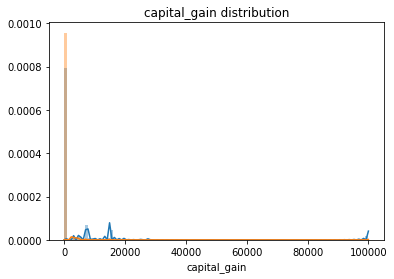

In [39]:
ax = sns.distplot(data3.loc[(data3[label]==1), "capital_gain"], label="label=1", bins=100)
sns.distplot(data3.loc[(data3[label]==0), "capital_gain"], label="label=0", bins=100)
ax.set_title("capital_gain distribution")

In [40]:
len(data3["capital_gain"].unique())

119

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'capital_gain distribution')

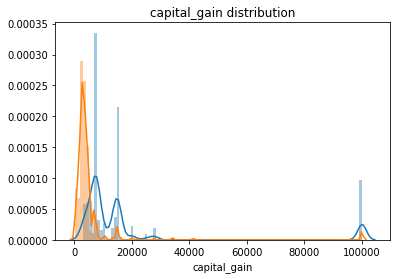

In [41]:
mask1 = (data3["capital_gain"]>0.0) & (data3[label]==1)
mask0 = (data3["capital_gain"]>0.0) & (data3[label]==0)
ax = sns.distplot(data3.loc[mask1, "capital_gain"], bins=100, label="label=1")
sns.distplot(data3.loc[mask0, "capital_gain"], bins=100, label="label=0")
ax.set_title("capital_gain distribution")

In [42]:
data3["capital_gain_bins"] = pd.cut(data3["capital_gain"], [np.NINF, 0.0, 20000, np.inf])
data3.groupby("capital_gain_bins")[label].agg([np.size, np.mean])

,size,mean
capital_gain_bins,,
"(-inf, 0.0]",29849.0,0.202378
"(0.0, 20000.0]",2459.0,0.546092
"(20000.0, inf]",253.0,0.877551


C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'capital_loss distribution')

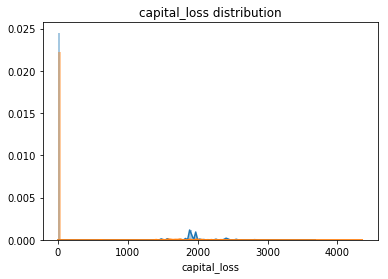

In [43]:
ax = sns.distplot(data3.loc[(data3[label]==1), "capital_loss"], label="label=1", bins=100)
sns.distplot(data3.loc[(data3[label]==0), "capital_loss"], label="label=0", bins=100)
ax.set_title("capital_loss distribution")

In [44]:
len(data3["capital_loss"].unique())

92

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'capital_loss distribution')

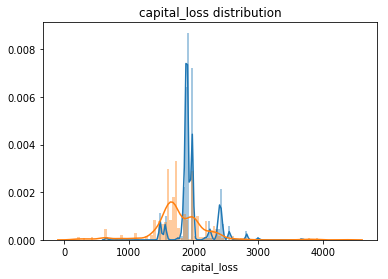

In [45]:
mask1 = (data3["capital_loss"]>0.0) & (data3[label]==1)
mask0 = (data3["capital_loss"]>0.0) & (data3[label]==0)
ax = sns.distplot(data3.loc[mask1, "capital_loss"], bins=100, label="label=1")
sns.distplot(data3.loc[mask0, "capital_loss"], bins=100, label="label=0")
ax.set_title("capital_loss distribution")

In [46]:
data3["capital_loss_bins"] = pd.cut(data3["capital_loss"], [np.NINF, 0.0, 1800, np.inf])
data3.groupby("capital_loss_bins")[label].agg([np.size, np.mean])

,size,mean
capital_loss_bins,,
"(-inf, 0.0]",31042.0,0.221545
"(0.0, 1800.0]",526.0,0.102564
"(1800.0, inf]",993.0,0.687166


C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'fnlwgt distribution')

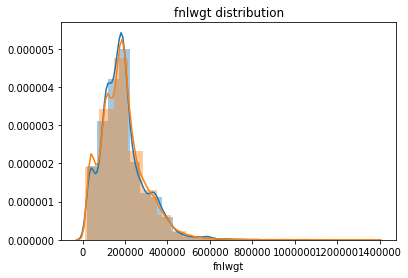

In [47]:
ax = sns.distplot(data3.loc[(data3[label]==1), "fnlwgt"], label="label=1", bins=20)
sns.distplot(data3.loc[(data3[label]==0), "fnlwgt"], label="label=0", bins=20)
ax.set_title("fnlwgt distribution")

In [48]:
data3["fnlwgt_buckets"] = pd.qcut(data3["fnlwgt"], 5, duplicates="drop")
data3.groupby("fnlwgt_buckets")[label].agg([np.size, np.mean])

,size,mean
fnlwgt_buckets,,
"(12284.999, 106648.0]",6513.0,0.225000
"(106648.0, 158662.0]",6512.0,0.249034
"(158662.0, 196338.0]",6512.0,0.247154
"(196338.0, 259873.0]",6512.0,0.217337
"(259873.0, 1484705.0]",6512.0,0.230658


In [49]:
data3["sex"] = np.where(data3["sex"]=="Male", 1,0)
data3["sex"].unique()

array([0, 1], dtype=int64)

## Bivariate EDA:

* Response Analysis
* Multicollinearity Analysis

**Response Analysis**

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Age distribution')

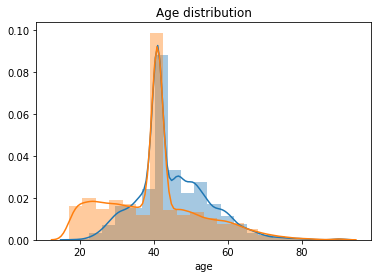

In [50]:
ax = sns.distplot(data3.loc[(data3[label]==1), "age"], label="label=1", bins=20)
sns.distplot(data3.loc[(data3[label]==0), "age"], label="label=0", bins=20)
ax.set_title("Age distribution")

In [51]:
data3["age_buckets"] = pd.qcut(data3["age"], 3)
data3.groupby("age_buckets")[label].agg([np.size, np.mean])

,size,mean
age_buckets,,
"(16.999, 39.0]",10954.0,0.150049
"(39.0, 42.0]",11059.0,0.216004
"(42.0, 90.0]",10548.0,0.340124


C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'hours_per_week distribution')

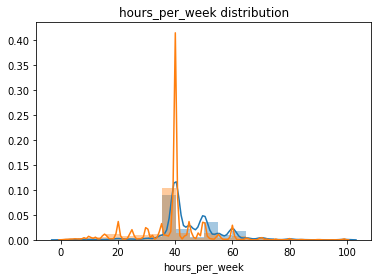

In [52]:
ax = sns.distplot(data3.loc[(data3[label]==1), "hours_per_week"], label="label=1", bins=20)
sns.distplot(data3.loc[(data3[label]==0), "hours_per_week"], label="label=0", bins=20)
ax.set_title("hours_per_week distribution")

In [53]:
data3["hours_per_week_buckets"] = pd.qcut(data3["hours_per_week"], 3, duplicates="drop")
data3.groupby("hours_per_week_buckets")[label].agg([np.size, np.mean])

,size,mean
hours_per_week_buckets,,
"(0.999, 40.0]",22980.0,0.168856
"(40.0, 99.0]",9581.0,0.388997


$$ WOE_{xj} = ln(\frac{p_{attribute}^{non-event}}{p_{attribute}^{event}})$$ 

$$ \text{smoothed } WOE_{xj} = ln(\frac{ \frac{N_{attribute}^{non-event}+\alpha}{N_{total}^{non-event}} }{ \frac{N_{attribute}^{event}+\alpha}{N_{total}^{event}} }) $$ 


$$ \alpha \text{ smoothing parameter between [0,1], by default=0.5}$$

$$ IV = \sum_{i=1}^{m}(\frac{N_{non-event}^{attr}}{N_{non-event}^{total}}-\frac{N_{event}^{attr}}{N_{event}^{total}})*WOE_{i}$$

In [54]:
def catFeatureEDA(df, label, feature, limit, smooth_param):
    eprop = df.groupby(feature)[label].agg([np.size, np.mean, np.sum]).rename(columns={"sum": "n1", "size": "n", "mean": "eprop"})
    #Compute total stats
    n = eprop["n"].sum()
    N1 = eprop["n1"].sum()
    N0 = n-N1
    
    eprop["n_pct"] = eprop["n"] / n
    eprop["n0"] = eprop["n"] - eprop["n1"]
    eprop["neprop"] = eprop["n0"] /  eprop["n"]
    eprop.reset_index(inplace=True)
    eprop.rename(columns={feature: "levels"}, inplace=True)
    eprop["WOE"] = np.log( ((eprop["n0"] + smooth_param)/N0) / ((eprop["n1"]+ smooth_param)/N1) )
    IV = ( eprop["WOE"]*((eprop["n0"]/N0)-(eprop["n1"]/N1)) ).sum()
    eprop["feature"] = feature
    eprop["IV"] = IV
    eprop.sort_values(by=["IV", "WOE"], ascending=[True, False], inplace=True)
    
    return eprop[:limit][["feature", "levels", "WOE", "IV", "eprop", "n_pct", "n1", "n0", "n"]]

In [55]:
feat_list = ['MI_age', 'OI_age',  'OI_hours_per_week', 'hours_per_week_buckets', 'age_buckets',
             'capital_gain_bins', 'capital_loss_bins', 'fnlwgt_buckets',
             'education', 'native_country',
            'marital_status', 'occupation', 'race','relationship', 'sex', 'workclass']

eprop_df_list = list(map(lambda feat: catFeatureEDA(data3[data3["flg_train"] == 1], label, feat, 10, 0.5), feat_list))
eprop = reduce(lambda a, b: a.append(b), eprop_df_list)
eprop[:10]

,feature,levels,WOE,IV,eprop,n_pct,n1,n0,n
1,MI_age,1,0.211326,0.017239,0.198138,0.294717,1426.0,5771.0,7197.0
0,MI_age,0,-0.081722,0.017239,0.248853,0.705283,4286.0,12937.0,17223.0
1,OI_age,1,0.236470,0.000275,0.191667,0.004914,23.0,97.0,120.0
0,OI_age,0,-0.001225,0.000275,0.234115,0.995086,5689.0,18611.0,24300.0
0,OI_hours_per_week,-1,0.537936,0.004051,0.146667,0.003071,11.0,64.0,75.0
1,OI_hours_per_week,0,0.004727,0.004051,0.233050,0.986282,5613.0,18472.0,24085.0
2,OI_hours_per_week,1,-0.518987,0.004051,0.338462,0.010647,88.0,172.0,260.0
0,hours_per_week_buckets,"(0.999, 40.0]",0.407237,0.292102,0.168856,0.704505,2905.0,14299.0,17204.0
1,hours_per_week_buckets,"(40.0, 99.0]",-0.734915,0.292102,0.388997,0.295495,2807.0,4409.0,7216.0
0,age_buckets,"(16.999, 39.0]",0.547506,0.190435,0.150049,0.337592,1237.0,7007.0,8244.0


In [56]:
eprop_IV = eprop[["feature", "IV"]].drop_duplicates().sort_values(by="IV",ascending=True)
eprop_IV["abs_IV"] = abs(eprop_IV["IV"])

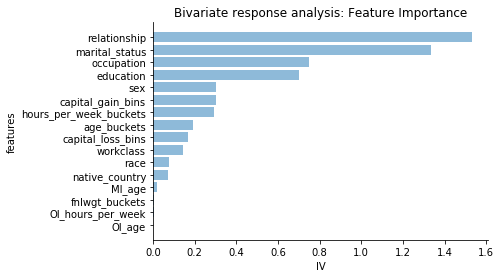

In [57]:
plt.barh(eprop_IV["feature"], eprop_IV["IV"], alpha=0.5)

ax = plt.gca()
frames = ax.spines
frames["right"].set_visible(False)
frames["top"].set_visible(False)

plt.xlabel("IV")
plt.ylabel("features")
plt.title('Bivariate response analysis: Feature Importance')
plt.show()

## Model Building

**Raw model**

In [58]:
raw_feat_list = ['age', 'hours_per_week' ,
             'capital_gain', 'capital_loss', 'fnlwgt',
             'education', 'native_country',
            'marital_status', 'occupation', 'race','relationship', 'sex', 'workclass']

In [59]:
data_fte = pd.get_dummies(data1[raw_feat_list + [label, 'flg_train']])
X = data_fte[data_fte['flg_train']==1].drop(['flg_train'], axis=1)
score = data_fte[data_fte['flg_train']==0].drop(['flg_train', label], axis=1)
y = X.pop(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

logreg = LogisticRegression().fit(X_train, y_train)

train_probs=logreg.predict_proba(X_train)[:,1]
test_probs=logreg.predict_proba(X_test)[:,1]

train_auc = roc_auc_score(y_train, train_probs) 
test_auc = roc_auc_score(y_test, test_probs) 

print("Train AUC: {} \nTest AUC: {}".format(train_auc, test_auc))

Train AUC: 0.5889632762511274 
Test AUC: 0.570821872822286


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [60]:
feat_list = ['MI_age', 'OI_age',  'OI_hours_per_week', 'age', 'hours_per_week' ,
             'capital_gain_bins', 'capital_loss_bins', 'fnlwgt_buckets',
             'education', 'native_country',
            'marital_status', 'occupation', 'race','relationship', 'sex', 'workclass']

**Feature Engineering + Logitic Regression**

In [61]:
from sklearn.model_selection import GridSearchCV

feat_list = ['MI_age', 'age_buckets',  'hours_per_week', 'hours_per_week_buckets' ,
             'capital_gain_bins', 'capital_loss_bins', 'fnlwgt_buckets',
             'education', 'native_country',
            'marital_status', 'occupation', 'race','relationship', 'sex', 'workclass']


data3_fte = pd.get_dummies(data3[feat_list + [label, 'flg_train']])
X = data3_fte[data3_fte['flg_train']==1].drop(['flg_train'], axis=1)
score = data3_fte[data3_fte['flg_train']==0].drop(['flg_train', label], axis=1)
y = X.pop(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

param_grid = {'C':[0.001, 0.01, 0.1, 1.0, 10.0]}
logreg_cv = GridSearchCV(LogisticRegression(penalty='l1'), param_grid, cv=5, scoring="roc_auc", refit=True).fit(X_train, y_train)

train_probs=logreg_cv.predict_proba(X_train)[:,1]
test_probs=logreg_cv.predict_proba(X_test)[:,1]

cv_auc = logreg_cv.best_score_ 
train_auc = roc_auc_score(y_train, train_probs) 
test_auc = roc_auc_score(y_test, test_probs) 

print("CV AUC: {} \nTrain AUC: {} \nTest AUC: {}".format(cv_auc, train_auc, test_auc))

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


CV AUC: 0.8951054912954158 
Train AUC: 0.8984564368340435 
Test AUC: 0.8999838663761227


In [62]:
cv_results= zip(logreg_cv.cv_results_['mean_test_score'], logreg_cv.cv_results_['params'])
sorted(cv_results, key=lambda pair: pair[0], reverse=True)

[(0.8951054912954158, {'C': 1.0}),
 (0.8949465282549057, {'C': 10.0}),
 (0.8923100359319294, {'C': 0.1}),
 (0.8657113694437122, {'C': 0.01}),
 (0.5465671040532913, {'C': 0.001})]

## Model Assessment

### Posterior probability distribution

In [63]:
test_scored_df = pd.DataFrame({"y_test": y_test, "test_probs": test_probs})
test_scored_df["prob_buckets"] = pd.qcut(test_scored_df["test_probs"], 100)

In [64]:
test_scored_df.groupby("y_test").agg(np.mean)

,test_probs
y_test,
0.0,0.135467
1.0,0.548498


C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Posterior distribution by label')

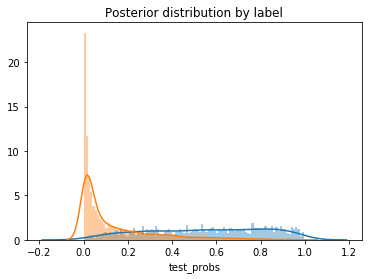

In [65]:
mask1 = (test_scored_df["y_test"]==1.0)
mask0 = (test_scored_df["y_test"]==0.0)
ax = sns.distplot(test_scored_df.loc[mask1, "test_probs"], bins=100, label="label=1")
sns.distplot(test_scored_df.loc[mask0, "test_probs"], bins=100, label="label=0")
ax.set_title("Posterior distribution by label")

### Accuracy Plot

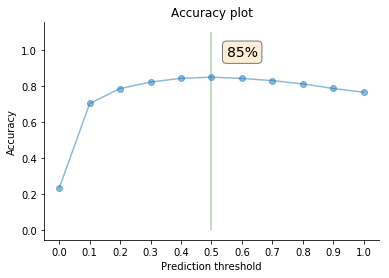

In [66]:
pred_thresholds = np.linspace(0.0,1.0, 11)
test_acc = []
for threshold in pred_thresholds:
    test_preds=np.where(test_probs>=threshold, 1,0)
    acc=accuracy_score(y_test,test_preds)
    test_acc = test_acc + [acc]



ax = plt.gca()
frames = ax.spines
frames["right"].set_visible(False)
frames["top"].set_visible(False)

plt.plot(pred_thresholds, test_acc, '-o', alpha=0.5)
h_acc_max=pred_thresholds[np.argmax(test_acc)]
max_acc=np.max(test_acc)

ax.vlines(x=h_acc_max, ymin=0.0, ymax=1.1, linewidth=2, color='g', alpha=0.25)

ax.set_xticks(pred_thresholds, minor=False)

textStr = "{0:.0%}".format(max_acc)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05+h_acc_max, 0.95, textStr, fontsize=14, verticalalignment='bottom', bbox=props)


plt.xlabel("Prediction threshold")
plt.ylabel("Accuracy")
plt.title('Accuracy plot')
plt.show()

### Calibration Plot

In [67]:
test_calibration_df = test_scored_df.groupby("prob_buckets")["y_test", "test_probs"].agg(np.mean)
#test_calibration_df.rename({"y_test": "prior", "test_probs":"posterior"}, inplace=True)

test_calibration_df[:5]

,y_test,test_probs
prob_buckets,,
"(-0.000769, 0.00104]",0.0,0.000725
"(0.00104, 0.0015]",0.0,0.001286
"(0.0015, 0.00189]",0.0,0.001682
"(0.00189, 0.00234]",0.0,0.002107
"(0.00234, 0.00283]",0.0,0.002576


C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Calibration plot')

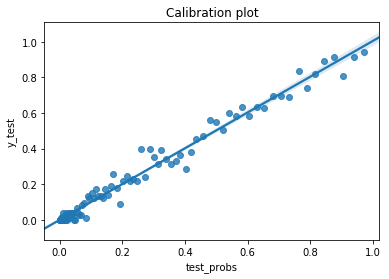

In [68]:
ax = sns.regplot(test_calibration_df["test_probs"], test_calibration_df["y_test"])
ax.set_title("Calibration plot")